In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")# Ignore all warnings
from datetime import datetime, timedelta
# warnings.filterwarnings("default")

In [2]:
naming_key = pd.read_excel('../raw_data/naming_convension.xlsx',sheet_name='keys')
naming_demo = pd.read_excel('../raw_data/naming_convension.xlsx',sheet_name='Demographic')
naming_neuro = pd.read_excel('../raw_data/naming_convension.xlsx',sheet_name='neuropsychological')
naming = pd.concat([naming_key, naming_demo, naming_neuro], ignore_index=True)

## some help function

In [3]:
def calculate_visit_statistics(df):
    visit_counts = df.groupby('ID').size()
    visit_stats = {
        'average_visits': visit_counts.mean(),
        'min_visits': visit_counts.min(),
        'max_visits': visit_counts.max()
    }
    return visit_stats

In [4]:
def summarize_classification_progression(df):
    progression_dict = df.groupby('ID')['Classification'].apply(
        lambda x: [v for i, v in enumerate(x) if i == 0 or v != x.iloc[i-1]]
    ).to_dict()

    summary_map = {}
    for id, progression in progression_dict.items():
        progression_tuple = tuple(progression)
        if progression_tuple not in summary_map:
            summary_map[progression_tuple] = []
        summary_map[progression_tuple].append(id)

    for pattern, ids in summary_map.items():
        print(f"Progression Pattern: {pattern} -> RIDs: {ids}")
        print("with", len(ids), 'participants')

    return

def summarize_classification_progression_simple(df):
    progression_dict = df.groupby('ID')['Classification'].apply(
        lambda x: [x.iloc[0], x.iloc[-1]]
    ).to_dict()

    summary_map = {}
    for id, progression in progression_dict.items():
        progression_tuple = tuple(progression)
        if progression_tuple not in summary_map:
            summary_map[progression_tuple] = []
        summary_map[progression_tuple].append(id)

    for pattern, ids in summary_map.items():
        print(f"Progression Pattern: {pattern} -> RIDs: {ids}")
        print("with", len(ids), 'participants')

    return

In [5]:
def impute_demographic_data(df):
    df["Demographic.ApoE genotype"] = df.groupby("AIBL ID")["Demographic.ApoE genotype"].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

    education_mapping = {
        '0-6': (4, 6),
        '7-8': (7, 8),
        '9-12': (9, 12),
        '13-15': (13, 15),
        '15+': (16, 22)
    }

    def impute_years_of_education_exact(row):
        if pd.isna(row['Demographic.Years of Education Exact']) and row['Demographic.Years of Education'] in education_mapping:
            low, high = education_mapping[row['Demographic.Years of Education']]
            return np.random.default_rng(42).integers(low, high + 1) 
        return row['Demographic.Years of Education Exact']

    # Apply imputation function to each row
    df['Demographic.Years of Education Exact'] = df.apply(impute_years_of_education_exact, axis=1)

    return df

In [6]:
def generate_visit_column(df):
    # Sort values by ID and age
    df.sort_values(by=['ID', 'age'], inplace=True)

    # Calculate VISIT column
    def calculate_visit(group):
        first_age = group['age'].iloc[0]  # Age at first visit
        group['VISIT'] = ((group['age'] - first_age) * 12).astype(int)  # Difference in months as integer
        return group

    df = df.groupby('ID').apply(calculate_visit)

    # Resolve duplicate VISIT records
    def resolve_duplicates(group):
        # Add the index as a temporary column
        group['missing_count'] = group.isnull().sum(axis=1)
        group = group.sort_values(
            by=['VISIT', 'missing_count', 'age'],
            ascending=[True, True, False]
        )
        group = group.drop_duplicates(subset=['VISIT'], keep='first')
        group = group.drop(columns=['missing_count'])  # Clean up temporary columns
        return group

    df = df.groupby('ID').apply(resolve_duplicates)

    return df.reset_index(drop=True)



## AIBL

In [7]:
AIBL_raw = pd.read_excel('../raw_data/AIBL_2023.xlsx')
AIBL_raw['Demographic.YearMonthOfBirth']=AIBL_raw['Demographic.YearMonthOfBirth'].astype(str) + '01'
AIBL_raw['Demographic.YearMonthOfBirth'] = pd.to_datetime(AIBL_raw['Demographic.YearMonthOfBirth'], format='%Y%m%d')
AIBL_raw['Progress Summary.Date of NP assessment'] = pd.to_datetime(AIBL_raw['Progress Summary.Date of NP assessment'], format='%d/%m/%Y')
AIBL_raw['Age'] = round((AIBL_raw['Progress Summary.Date of NP assessment'] - AIBL_raw['Demographic.YearMonthOfBirth']).dt.days / 365, 2)
AIBL_raw = impute_demographic_data(AIBL_raw) ## only impute for education given the range but no exact value


In [8]:
AIBL_selected = AIBL_raw[naming['AIBL'].dropna().tolist()]
AIBL_selected.replace('NI', np.nan, inplace=True)
AIBL_selected = AIBL_selected.dropna(subset=['Age']).reset_index(drop=True)
AIBL_rename_dict = dict(zip(naming['AIBL'], naming['New_Name']))
AIBL_selected = AIBL_selected.rename(columns=AIBL_rename_dict)
AIBL_selected = generate_visit_column(AIBL_selected)

In [9]:
AIBL_selected.head(4)

,ID,Classification,age,sex,edu,APOE,BMI,blood_pressure_systolic,blood_pressure_diastolic,Heart_rate,...,NPIQ_Appetite_Sev,GDS,MMSE,memory_recall1,memory_recall2,Digit_Span_F,Digit_Span_B,animal,BNT,VISIT
0,2,HC,65.30,Male,16.0,E3/E3,24.82,130.0,80.0,66.0,...,NaN,2.0,29.0,15.0,14.0,9.0,5.0,40.0,NaN,0
1,2,HC,67.17,Male,16.0,E3/E3,24.40,135.0,85.0,64.0,...,NaN,NaN,30.0,9.0,8.0,12.0,10.0,51.0,30.0,22
2,2,HC,68.69,Male,16.0,E3/E3,23.40,121.0,69.0,62.0,...,NaN,0.0,30.0,20.0,18.0,13.0,10.0,42.0,30.0,40
3,2,HC,70.17,Male,16.0,E3/E3,24.66,142.0,77.0,57.0,...,NaN,1.0,30.0,16.0,14.0,13.0,9.0,46.0,30.0,58


## NACC

In [9]:
def add_age_column_NACC(df):
    df['VISITDATE'] = pd.to_datetime(
        dict(
            year=df['VISITYR'], 
            month=df['VISITMO'], 
            day=df['VISITDAY']
        )
    )
    df['BIRTHDATE'] = pd.to_datetime(
        dict(
            year=df['BIRTHYR'], 
            month=df['BIRTHMO'], 
            day=1
        )
    )
    df['AGE'] = (
        (df['VISITDATE'] - df['BIRTHDATE']).dt.total_seconds() 
        / (365.25 * 24 * 60 * 60)
    ).round(2)
    if 'NACCAGE' in df.columns:
        df['AGE'].fillna(df['NACCAGE'], inplace=True)
    return df


In [10]:
NACC_raw = pd.read_csv('../raw_data/investigator_ftldlbd_nacc66.csv',index_col=False)
NACC_raw = NACC_raw[['NACCID']].join(NACC_raw.select_dtypes(include=['number']))
NACC_raw.replace([-4, -4.4, 8, 9, 88, 99, 97, 98, 96, 95, 888, 999, 8888, 9999, 88.8, 888.8, 99.9, 777], np.nan, inplace=True)
NACC_raw = add_age_column_NACC(NACC_raw)
NACC_selected = NACC_raw[naming['NACC'].dropna().tolist()]
NACC_selected.replace('NI', np.nan, inplace=True)
NACC_selected = NACC_selected.dropna(subset=['AGE']).reset_index(drop=True)

In [11]:
## check for the recalculation of age value
age_difference = abs(NACC_raw['AGE'] - NACC_raw['NACCAGE'])
difference_check = age_difference > 1
rows_with_difference = NACC_raw[difference_check]
print(f"Number of rows with a difference > 1 year: {difference_check.sum()}")
rows_with_difference

Number of rows with a difference > 1 year: 0


,NACCID,NACCADC,FORMVER,VISITMO,VISITDAY,VISITYR,NACCVNUM,NACCAVST,NACCNVST,NACCDAYS,...,LBOTHAVL,LBOCGAIT,LBOCGMO,LBOCGYR,LBOCGDY,LBOCGPOS,LBOCGAVL,VISITDATE,BIRTHDATE,AGE


In [12]:
NACC_rename_dict = dict(zip(naming['NACC'], naming['New_Name']))
NACC_selected = NACC_selected.rename(columns=NACC_rename_dict)
NACC_selected = generate_visit_column(NACC_selected)
NACC_selected.head(4)

,ID,Classification,age,sex,edu,APOE,BMI,blood_pressure_systolic,blood_pressure_diastolic,Heart_rate,...,NPIQ_Appetite_Sev,GDS,MMSE,memory_recall1,memory_recall2,Digit_Span_F,Digit_Span_B,animal,BNT,VISIT
0,NACC000011,3,62.21,2,16.0,1.0,22.7,115.0,70.0,76.0,...,NaN,0.0,30.0,12.0,11.0,NaN,6.0,20.0,27.0,0
1,NACC000011,3,63.38,2,16.0,1.0,22.5,118.0,76.0,57.0,...,NaN,1.0,29.0,13.0,NaN,7.0,6.0,21.0,28.0,14
2,NACC000011,3,64.34,2,16.0,1.0,22.1,110.0,70.0,62.0,...,NaN,0.0,30.0,12.0,NaN,NaN,6.0,21.0,28.0,25
3,NACC000011,2,65.00,2,16.0,1.0,21.7,135.0,80.0,76.0,...,NaN,0.0,28.0,11.0,10.0,7.0,NaN,19.0,28.0,33


## Check

check between AIBL and NACC, make sure with the same data structure

In [13]:
NACC_selected['ID'] = NACC_selected['ID'].str.replace('NACC', '').astype(int)
NACC_selected['APOE'] = NACC_selected['APOE'].map({1:'E3/E3' , 2:'E3/E4', 3:'E3/E2', 4:'E4/E4', 5:'E3/E2', 6:'E2/E2'})
NACC_selected['APOE4'] = NACC_selected['APOE'].apply(lambda x: 1 if isinstance(x, str) and 'E4' in x.split('/') else (0 if isinstance(x, str) else None))
# NACC_selected['height'] = NACC_selected['height'] * 2.54 # inches to cm
# NACC_selected['weight'] = NACC_selected['weight'] * 0.453592 # lbs to kg
NACC_selected['Digit_Span_F'] = (NACC_selected['Digit_Span_F'] / 12) * 16 # convert the range from 0-12 to 0-16 be consistent (later in modelling will do normalisation)
NACC_selected['Digit_Span_B'] = (NACC_selected['Digit_Span_F'] / 12) * 14 # convert the range from 0-12 to 0-14 be consistent (later in modelling will do normalisation)

NACC_selected['Classification'] = NACC_selected['Classification'].map({1:'HC' , 3:'MCI', 4:'AD'})
NACC_selected = NACC_selected[NACC_selected['Classification'].isin(['HC', 'MCI'])]
NACC_selected.head(4)

,ID,Classification,age,sex,edu,APOE,BMI,blood_pressure_systolic,blood_pressure_diastolic,Heart_rate,...,GDS,MMSE,memory_recall1,memory_recall2,Digit_Span_F,Digit_Span_B,animal,BNT,VISIT,APOE4
0,11,MCI,62.21,2,16.0,E3/E3,22.7,115.0,70.0,76.0,...,0.0,30.0,12.0,11.0,NaN,NaN,20.0,27.0,0,0.0
1,11,MCI,63.38,2,16.0,E3/E3,22.5,118.0,76.0,57.0,...,1.0,29.0,13.0,NaN,9.333333,10.888889,21.0,28.0,14,0.0
2,11,MCI,64.34,2,16.0,E3/E3,22.1,110.0,70.0,62.0,...,0.0,30.0,12.0,NaN,NaN,NaN,21.0,28.0,25,0.0
4,34,MCI,79.00,2,15.0,E4/E4,23.0,169.0,76.0,73.0,...,0.0,NaN,NaN,NaN,NaN,NaN,15.0,NaN,0,1.0


In [14]:
AIBL_selected['sex'] = AIBL_selected['sex'].map({'Female': 2, 'Male': 1})
AIBL_selected['APOE4'] = AIBL_selected['APOE'].apply(lambda x: 1 if isinstance(x, str) and 'E4' in x.split('/') else (0 if isinstance(x, str) else None))

NPIQ_cols_convert_AIBL = ['NPIQ_Delusions', 'NPIQ_Hallucinations', 'NPIQ_Agitation', 'NPIQ_Depression', 'NPIQ_Anxiety', 'NPIQ_Elation', 'NPIQ_Apathy', 'NPIQ_Disinhibition','NPIQ_Irritability', 'NPIQ_Motor', 'NPIQ_Nighttime', 'NPIQ_Appetite']
AIBL_selected[NPIQ_cols_convert_AIBL] = AIBL_selected[NPIQ_cols_convert_AIBL].replace({'Yes': 1, 'No': 0})
NPIQ_cols_numeric_AIBL = ['NPIQ_Hallucinations_Sev', 'NPIQ_Depression_Sev', 'NPIQ_Anxiety_Sev', 'NPIQ_Elation_Sev', 'NPIQ_Apathy_Sev', 'NPIQ_Disinhibition_Sev', 'NPIQ_Irritability_Sev', 'NPIQ_Motor_Sev', 'NPIQ_Nighttime_Sev', 'NPIQ_Appetite_Sev']  
AIBL_selected[NPIQ_cols_numeric_AIBL] = AIBL_selected[NPIQ_cols_numeric_AIBL].apply(pd.to_numeric, errors='coerce')

AIBL_selected['Classification'] = AIBL_selected['Classification'].replace('MCIX', 'MCI')
AIBL_selected = AIBL_selected[AIBL_selected['Classification'].isin(['HC', 'MCI'])] # Keep only rows where the 'classification' column contains 'HC', 'MCI', or 'AD'
AIBL_selected.head(4)

,ID,Classification,age,sex,edu,APOE,BMI,blood_pressure_systolic,blood_pressure_diastolic,Heart_rate,...,GDS,MMSE,memory_recall1,memory_recall2,Digit_Span_F,Digit_Span_B,animal,BNT,VISIT,APOE4
0,2,HC,65.30,1,16.0,E3/E3,24.82,130.0,80.0,66.0,...,2.0,29.0,15.0,14.0,9.0,5.0,40.0,NaN,0,0.0
1,2,HC,67.17,1,16.0,E3/E3,24.40,135.0,85.0,64.0,...,NaN,30.0,9.0,8.0,12.0,10.0,51.0,30.0,22,0.0
2,2,HC,68.69,1,16.0,E3/E3,23.40,121.0,69.0,62.0,...,0.0,30.0,20.0,18.0,13.0,10.0,42.0,30.0,40,0.0
3,2,HC,70.17,1,16.0,E3/E3,24.66,142.0,77.0,57.0,...,1.0,30.0,16.0,14.0,13.0,9.0,46.0,30.0,58,0.0


## Filter 

In [15]:
def check_classification(group_df):
    group_df = group_df.sort_values(by='age')
    first_non_missing = group_df['Classification'].first_valid_index()
    last_non_nan = group_df['Classification'].last_valid_index()
    mci_detected = False
    for idx, row in group_df.iterrows():
        if row['Classification'] == 'MCI':
            mci_detected = True
        elif mci_detected and row['Classification'] != 'MCI':
            group_df = group_df.loc[:idx - 1]
            break
    return group_df

def drop_record_num(df, num=1):
    id_counts = df['ID'].value_counts()
    valid_ids = id_counts[id_counts > num].index
    return df[df['ID'].isin(valid_ids)].reset_index(drop=True)

def drop_missing_records(df, threshold=0.6):
    return df[df.isnull().mean(axis=1) <= threshold]

In [16]:
def remove_after_first_mci(df):
    def truncate_after_mci(group):
        mci_indices = group[group['Classification'] == 'MCI'].index
        if not mci_indices.empty:
            return group.loc[:mci_indices[0]]
        return group

    df = df.sort_values(by=['ID', 'age']).groupby('ID', group_keys=False).apply(truncate_after_mci).reset_index(drop=True)
    return df

In [17]:
def filter_records(group):
    while len(group) > 1 and (group['VISIT'].iloc[-1] - group['VISIT'].iloc[-2] < 6):
        group = group.iloc[:-2].append(group.iloc[-1:])  # Remove second last record
    return group

In [18]:
print("the shape of DF", NACC_selected.shape, "There are ", len(NACC_selected["ID"].unique()), "unique participants")
NACC_filter = NACC_selected.sort_values(by=['ID', 'VISIT'])
NACC_filter = NACC_filter[NACC_filter.columns[~NACC_filter.columns.str.startswith('NPIQ')]]

NACC_filter = drop_missing_records(NACC_filter, threshold=0)
participants_to_remove = NACC_filter.groupby('ID').first().query("Classification == 'MCI'").index
NACC_filter = NACC_filter[~NACC_filter['ID'].isin(participants_to_remove)]
NACC_filter = NACC_filter.groupby('ID').apply(check_classification).reset_index(drop=True)
NACC_filter = remove_after_first_mci(NACC_filter)
NACC_filter = drop_record_num(NACC_filter, num=3)
NACC_filter = NACC_filter.groupby('ID', group_keys=False).apply(filter_records)
NACC_filter['VISIT'] = NACC_filter.groupby('ID')['VISIT'].transform(lambda x: x - x.min())
print("the shape of DF", NACC_filter.shape, "There are ", len(NACC_filter["ID"].unique()), "unique participants")

the shape of DF (124608, 43) There are  34111 unique participants
the shape of DF (9131, 21) There are  1702 unique participants


In [19]:
print("the shape of DF", AIBL_selected.shape, "There are ", len(AIBL_selected["ID"].unique()), "unique participants")
AIBL_filter = AIBL_selected.sort_values(by=['ID', 'VISIT'])
AIBL_filter = AIBL_filter[AIBL_filter.columns[~AIBL_filter.columns.str.startswith('NPIQ')]]
AIBL_filter = drop_missing_records(AIBL_filter, threshold=0.3)
participants_to_remove = AIBL_filter.groupby('ID').first().query("Classification == 'MCI'").index
AIBL_filter = AIBL_filter[~AIBL_filter['ID'].isin(participants_to_remove)]
AIBL_filter = AIBL_filter.groupby('ID').apply(check_classification).reset_index(drop=True)
AIBL_filter = remove_after_first_mci(AIBL_filter)
AIBL_filter = drop_record_num(AIBL_filter,num=3)
AIBL_filter = AIBL_filter.groupby('ID', group_keys=False).apply(filter_records)
AIBL_filter['VISIT'] = AIBL_filter.groupby('ID')['VISIT'].transform(lambda x: x - x.min())
print("the shape of DF", AIBL_filter.shape, "There are ", len(AIBL_filter["ID"].unique()), "unique participants")

the shape of DF (8048, 43) There are  1993 unique participants
the shape of DF (5516, 21) There are  830 unique participants


In [20]:
AIBL_selected

,ID,Classification,age,sex,edu,APOE,BMI,blood_pressure_systolic,blood_pressure_diastolic,Heart_rate,...,GDS,MMSE,memory_recall1,memory_recall2,Digit_Span_F,Digit_Span_B,animal,BNT,VISIT,APOE4
0,2,HC,65.30,1,16.0,E3/E3,24.82,130.0,80.0,66.0,...,2.0,29.0,15.0,14.0,9.0,5.0,40.0,NaN,0,0.0
1,2,HC,67.17,1,16.0,E3/E3,24.40,135.0,85.0,64.0,...,NaN,30.0,9.0,8.0,12.0,10.0,51.0,30.0,22,0.0
2,2,HC,68.69,1,16.0,E3/E3,23.40,121.0,69.0,62.0,...,0.0,30.0,20.0,18.0,13.0,10.0,42.0,30.0,40,0.0
3,2,HC,70.17,1,16.0,E3/E3,24.66,142.0,77.0,57.0,...,1.0,30.0,16.0,14.0,13.0,9.0,46.0,30.0,58,0.0
4,2,HC,71.74,1,16.0,E3/E3,25.09,150.0,72.0,54.0,...,1.0,30.0,14.0,15.0,11.0,10.0,41.0,30.0,77,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9845,2999,MCI,88.34,1,NaN,NaN,24.37,158.0,73.0,74.0,...,2.0,30.0,10.0,6.0,7.0,6.0,39.0,28.0,18,NaN
9849,3004,MCI,70.84,1,NaN,NaN,22.27,127.0,91.0,58.0,...,0.0,22.0,1.0,0.0,15.0,12.0,24.0,27.0,18,NaN
9857,3014,HC,67.61,1,NaN,NaN,23.19,147.0,73.0,62.0,...,0.0,30.0,11.0,9.0,11.0,11.0,45.0,28.0,15,NaN
9869,3029,HC,70.26,1,NaN,NaN,32.37,155.0,92.0,83.0,...,0.0,30.0,11.0,7.0,11.0,7.0,28.0,30.0,14,NaN


In [21]:
calculate_visit_statistics(AIBL_filter)

{'average_visits': 6.645783132530121, 'min_visits': 4, 'max_visits': 11}

In [22]:
(AIBL_filter.isna().mean() * 100).sort_values(ascending=False)

GDS                         12.237128
BMI                          7.342277
Heart_rate                   6.780276
blood_pressure_diastolic     6.580856
blood_pressure_systolic      6.381436
Digit_Span_F                 0.815809
Digit_Span_B                 0.815809
animal                       0.525743
BNT                          0.489485
memory_recall2               0.217549
APOE4                        0.163162
APOE                         0.163162
edu                          0.126904
MMSE                         0.108774
memory_recall1               0.108774
CDR_SB                       0.072516
Classification               0.000000
sex                          0.000000
age                          0.000000
VISIT                        0.000000
ID                           0.000000
dtype: float64

In [23]:
NACC_ID_delete = [549156, 629312] ### just ensure all the participants for CU-MCI converter involved for MCI is inside CU/MCI - AD converter
NACC_filter = NACC_filter[~NACC_filter['ID'].isin(NACC_ID_delete)]

In [24]:
NACC_filter.to_csv('../preprocessed_data/NACC_selected_MCI.csv', index=False)
AIBL_filter.to_csv('../preprocessed_data/AIBL_selected_MCI.csv', index=False)

In [25]:
summarize_classification_progression_simple(NACC_filter)

Progression Pattern: ('HC', 'HC') -> RIDs: [992, 1504, 2122, 2616, 2720, 3052, 6569, 7406, 11828, 11922, 12212, 12235, 12716, 13409, 13771, 14377, 16407, 16412, 17109, 17294, 17516, 17546, 19799, 19892, 20513, 20530, 21360, 22920, 24559, 25199, 25918, 26743, 27516, 30140, 30148, 33850, 34386, 37267, 37512, 37828, 38012, 38544, 38862, 39029, 39761, 40262, 41238, 41386, 42697, 43527, 47077, 48262, 48656, 48812, 49677, 49982, 50166, 50382, 50540, 51164, 52136, 53049, 53257, 53791, 54587, 55186, 55874, 56647, 57935, 57953, 58667, 59326, 60082, 60203, 61124, 61437, 62801, 63098, 63626, 64627, 65263, 65909, 65923, 66764, 66770, 67919, 68322, 69309, 69426, 71910, 72185, 73892, 74581, 74916, 75911, 76213, 76374, 76774, 77761, 78090, 79574, 79781, 80728, 83470, 83687, 83765, 84809, 85020, 86678, 86778, 86890, 87595, 88963, 89122, 89251, 90639, 91298, 91708, 93264, 93935, 94523, 94571, 94661, 95188, 95374, 95384, 95791, 96054, 96601, 96892, 97008, 97310, 97453, 97580, 97770, 98351, 101261, 10127

In [26]:
summarize_classification_progression_simple(AIBL_filter)

Progression Pattern: ('HC', 'HC') -> RIDs: [2, 6, 11, 13, 14, 18, 21, 22, 24, 25, 26, 27, 29, 31, 32, 39, 43, 44, 45, 46, 50, 51, 52, 54, 55, 59, 60, 61, 62, 64, 67, 68, 72, 73, 74, 75, 78, 79, 80, 85, 88, 90, 97, 98, 101, 105, 117, 120, 121, 122, 127, 128, 129, 131, 132, 136, 137, 138, 139, 140, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 158, 161, 163, 165, 166, 167, 168, 171, 174, 175, 176, 178, 179, 181, 182, 183, 185, 186, 187, 190, 191, 193, 194, 197, 198, 200, 201, 204, 205, 206, 209, 211, 213, 214, 215, 219, 220, 221, 223, 225, 226, 228, 229, 231, 233, 234, 235, 236, 237, 239, 241, 242, 243, 244, 245, 247, 249, 250, 252, 253, 254, 255, 258, 260, 262, 263, 264, 265, 266, 267, 268, 269, 272, 275, 276, 279, 280, 281, 282, 283, 284, 286, 287, 289, 290, 292, 293, 297, 298, 299, 301, 304, 305, 307, 308, 311, 312, 313, 314, 316, 317, 318, 319, 322, 323, 324, 326, 328, 329, 333, 334, 337, 338, 339, 341, 343, 344, 350, 352, 355, 358, 359, 362, 363, 364, 367, 379, 381, 38

In [27]:
calculate_visit_statistics(AIBL_filter)

{'average_visits': 6.645783132530121, 'min_visits': 4, 'max_visits': 11}

In [28]:
calculate_visit_statistics(NACC_filter)

{'average_visits': 5.365882352941177, 'min_visits': 3, 'max_visits': 14}

In [29]:
def calculate_stats(df, dataset_name):
    df = df.sort_values(by=['ID', 'VISIT'])
    baseline = df.groupby('ID').first().reset_index()

    age_mean = baseline['age'].mean()
    age_std = baseline['age'].std()

    gender_female_count = (baseline['sex'] == 2).sum()
    gender_female_percentage = (gender_female_count / len(baseline)) * 100

    education_mean = baseline['edu'].mean()
    education_std = baseline['edu'].std()

    APOE4_positive_count = (baseline['APOE4'] == 1).sum()
    APOE4_positive_percentage = (APOE4_positive_count / len(baseline)) * 100

    num_visits = df.groupby('ID')['VISIT'].count()
    num_visits_mean = num_visits.mean()
    num_visits_std = num_visits.std()

    follow_up_intervals = df.groupby('ID')['VISIT'].agg(['min', 'max'])
    follow_up_range = f"{follow_up_intervals['max'].min()} - {follow_up_intervals['max'].max()} months"

    last_record_intervals = df.groupby('ID')['VISIT'].agg(lambda x: abs(x.nlargest(2).diff().iloc[-1]))
    follow_up_range_last = f"{last_record_intervals.min()} - {last_record_intervals.max()} months"

    df['MCI_converter'] = df['Classification'].eq('MCI').astype(int)
    MCI_converters = df.groupby('ID')['MCI_converter'].max().reset_index()
    MCI_conversion_count = MCI_converters['MCI_converter'].sum()
    MCI_conversion_percentage = (MCI_conversion_count / MCI_converters.shape[0]) * 100

    converters = df[df['ID'].isin(MCI_converters[MCI_converters['MCI_converter'] == 1]['ID'])]
    if not converters.empty:
        time_to_conversion = converters[converters['Classification'] == 'MCI'].groupby('ID')['VISIT'].min()
        time_to_conversion_mean = time_to_conversion.mean()
        time_to_conversion_std = time_to_conversion.std()
    else:
        time_to_conversion_mean = None
        time_to_conversion_std = None
    return {
        'Dataset': dataset_name,
        'Age at Baseline': f"{age_mean:.1f} ± {age_std:.1f}",
        'Gender (Female, n, %)': f"{gender_female_count} ({gender_female_percentage:.1f}%)",
        'Education (years, mean ± std)': f"{education_mean:.1f} ± {education_std:.1f}",
        'APOE4 Positive (n, %)': f"{APOE4_positive_count} ({APOE4_positive_percentage:.1f}%)",
        'Visits (mean ± std)': f"{num_visits_mean:.1f} ± {num_visits_std:.1f}",
        'Follow-up Interval': follow_up_range,
        'Follow-up Interval Last': follow_up_range_last,
        'MCI Conversion (n, %)': f"{MCI_conversion_count} ({MCI_conversion_percentage:.1f}%)",
        'Time to MCI Conversion (mean ± std)': f"{time_to_conversion_mean:.1f} ± {time_to_conversion_std:.1f}" if time_to_conversion_mean else "N/A"
    }

datasets = [(NACC_filter, "NACC"), (AIBL_filter, "AIBL")]
summary_stats = pd.DataFrame()
for cur_df, cur_df_name in datasets:
    summary_stats = pd.concat([summary_stats, pd.DataFrame([calculate_stats(cur_df, cur_df_name)])], ignore_index=True)
summary_stats


,Dataset,Age at Baseline,"Gender (Female, n, %)","Education (years, mean ± std)","APOE4 Positive (n, %)",Visits (mean ± std),Follow-up Interval,Follow-up Interval Last,"MCI Conversion (n, %)",Time to MCI Conversion (mean ± std)
0,NACC,71.5 ± 8.9,1145 (67.4%),16.1 ± 2.7,448 (26.4%),5.4 ± 1.6,25 - 202 months,6.0 - 156.0 months,114 (6.7%),81.6 ± 28.8
1,AIBL,70.1 ± 6.5,469 (56.5%),12.7 ± 3.2,208 (25.1%),6.6 ± 2.3,39 - 189 months,11.0 - 73.0 months,89 (10.7%),89.9 ± 37.2


## prepare for later survival analysis

In [30]:
def prepare_for_survival_analysis(df):
    df = df.sort_values(by=['ID', 'VISIT']).copy()
    
    
    def process_group(group):
        group['start'] = group['VISIT']
        group['stop'] = group['VISIT'].shift(-1)
        group['event'] = 0
        mci_indices = group[group['Classification'] == 'MCI'].index.tolist()
        if mci_indices:
            first_mci_idx = mci_indices[0]
            # last_ad_idx = ad_indices[-1]
            first_mci_stop = group.loc[first_mci_idx, 'VISIT']
            retained = group.loc[:first_mci_idx - 1].copy()
            if not retained.empty:
                retained.iloc[-1, retained.columns.get_loc('event')] = 1
                retained.iloc[-1, retained.columns.get_loc('stop')] = first_mci_stop
            return retained
        else:
            group = group.dropna(subset=['stop'])
            # group = group[group['stop'] != 0]
            # No 'MCI' occurrence; retain all records with 'event' as 0
            return group.copy()
    
    # Apply the processing to each group
    df_processed = df.groupby('ID').apply(process_group).reset_index(drop=True)
    df_processed = df_processed.drop(columns=['VISIT'])
    return df_processed

In [31]:
NACC_survival = prepare_for_survival_analysis(NACC_filter)
NACC_survival = drop_record_num(NACC_survival)
print("There are", NACC_survival['ID'].nunique(), "unique participants selected, with ", round((NACC_survival['event'].sum()/NACC_survival['ID'].nunique())*100, 2), "% convert to MCI in NACC")


AIBL_survival = prepare_for_survival_analysis(AIBL_filter)
AIBL_survival= drop_record_num(AIBL_survival)
print("There are", AIBL_survival['ID'].nunique(), "unique participants selected, with ", round((AIBL_survival['event'].sum()/AIBL_survival['ID'].nunique())*100, 2), "% convert to MCI in AIBL")

There are 1700 unique participants selected, with  6.71 % convert to MCI in NACC
There are 830 unique participants selected, with  10.72 % convert to MCI in AIBL


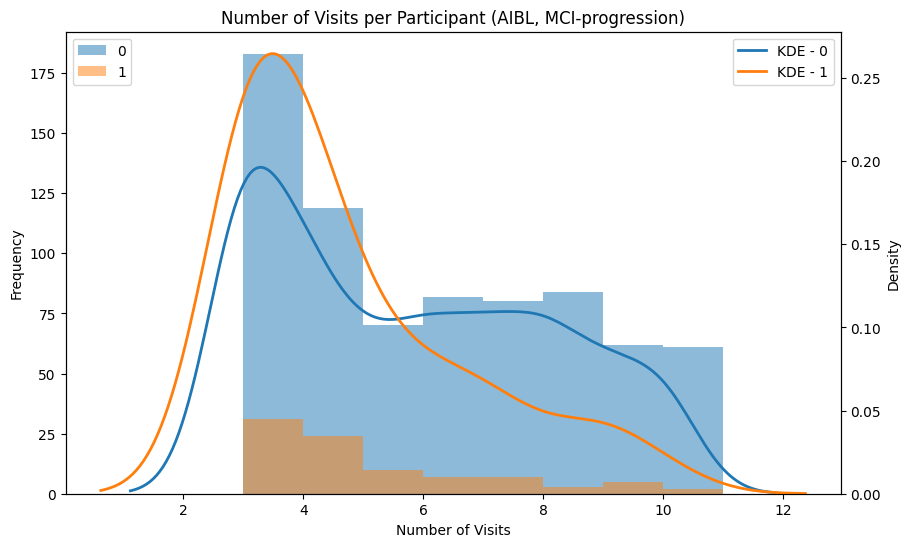

In [32]:
visit_counts = AIBL_survival.groupby('ID').size().reset_index(name='Visit_Count')
AIBL_last_record = AIBL_survival.groupby('ID').last().reset_index()


df_merged = pd.merge(visit_counts, AIBL_last_record[['ID', 'event']], on='ID', how = 'inner')

fig, ax1 = plt.subplots(figsize=(10, 6))
for event, group in df_merged.groupby('event'):
    ax1.hist(group['Visit_Count'], bins=range(1, df_merged['Visit_Count'].max() + 2),
             alpha=0.5, label=event)

ax1.set_xlabel('Number of Visits')
ax1.set_ylabel('Frequency')
ax1.set_title('Number of Visits per Participant (AIBL, MCI-progression)')
ax1.legend(title='Event')

# Create a second y-axis for KDE curve
ax2 = ax1.twinx()
for event, group in df_merged.groupby('event'):
    sns.kdeplot(group['Visit_Count'], ax=ax2, label=f'KDE - {event}', linewidth=2)
ax2.set_ylabel('Density')


# Adjust legend placement
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

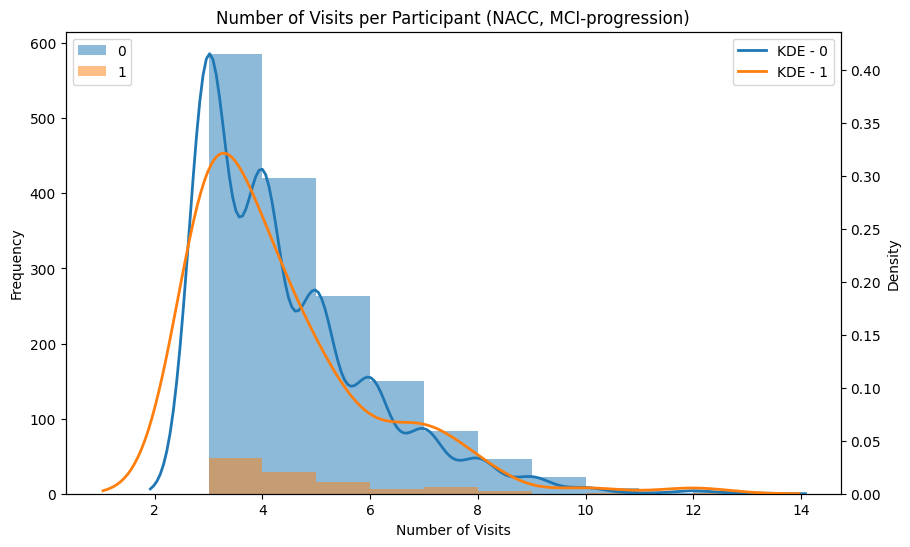

In [31]:
visit_counts = NACC_survival.groupby('ID').size().reset_index(name='Visit_Count')
AIBL_last_record = NACC_survival.groupby('ID').last().reset_index()


df_merged = pd.merge(visit_counts, AIBL_last_record[['ID', 'event']], on='ID', how = 'inner')
fig, ax1 = plt.subplots(figsize=(10, 6))
for event, group in df_merged.groupby('event'):
    ax1.hist(group['Visit_Count'], bins=range(1, df_merged['Visit_Count'].max() + 2),
             alpha=0.5, label=event)

ax1.set_xlabel('Number of Visits')
ax1.set_ylabel('Frequency')
ax1.set_title('Number of Visits per Participant (NACC, MCI-progression)')
ax1.legend(title='Event')

# Create a second y-axis for KDE curve
ax2 = ax1.twinx()
for event, group in df_merged.groupby('event'):
    sns.kdeplot(group['Visit_Count'], ax=ax2, label=f'KDE - {event}', linewidth=2)
ax2.set_ylabel('Density')


# Adjust legend placement
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

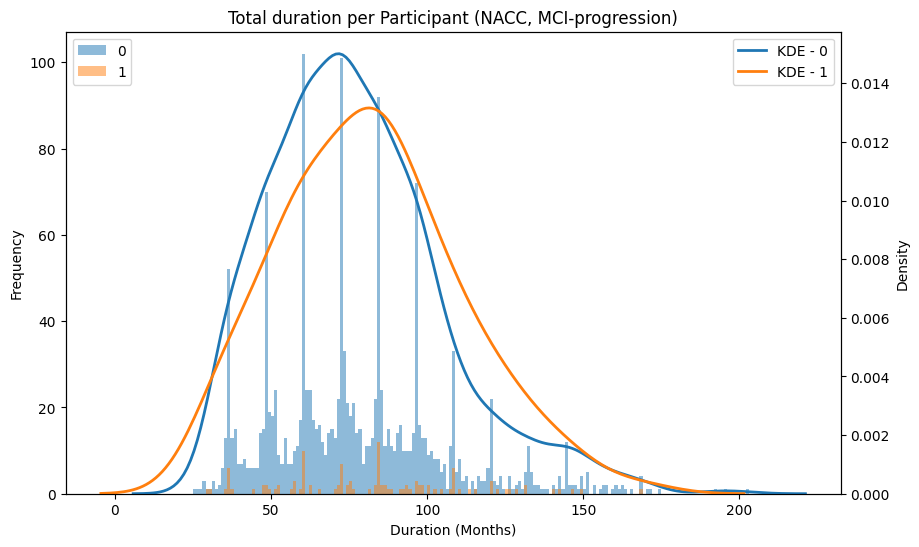

In [32]:
last_event = NACC_survival.groupby('ID').last().reset_index()[['ID', 'event']]

# Calculate time duration (max(End) - min(Start))
time_duration = NACC_survival.groupby('ID').agg({'start': 'min', 'stop': 'max'}).reset_index()
time_duration['Time'] = time_duration['stop'] - time_duration['start']

# Merge both
final_df = last_event.merge(time_duration[['ID', 'Time']], on='ID')
final_df['Time'] = final_df['Time'].astype(int)

fig, ax1 = plt.subplots(figsize=(10, 6))
for event, group in final_df.groupby('event'):
    ax1.hist(group['Time'], bins=range(1, final_df['Time'].max() + 2),
             alpha=0.5, label=event)

ax1.set_xlabel('Duration (Months)')
ax1.set_ylabel('Frequency')
ax1.set_title('Total duration per Participant (NACC, MCI-progression)')
ax1.legend(title='Event')

# Create a second y-axis for KDE curve
ax2 = ax1.twinx()
for event, group in final_df.groupby('event'):
    sns.kdeplot(group['Time'], ax=ax2, label=f'KDE - {event}', linewidth=2)
ax2.set_ylabel('Density')


# Adjust legend placement
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

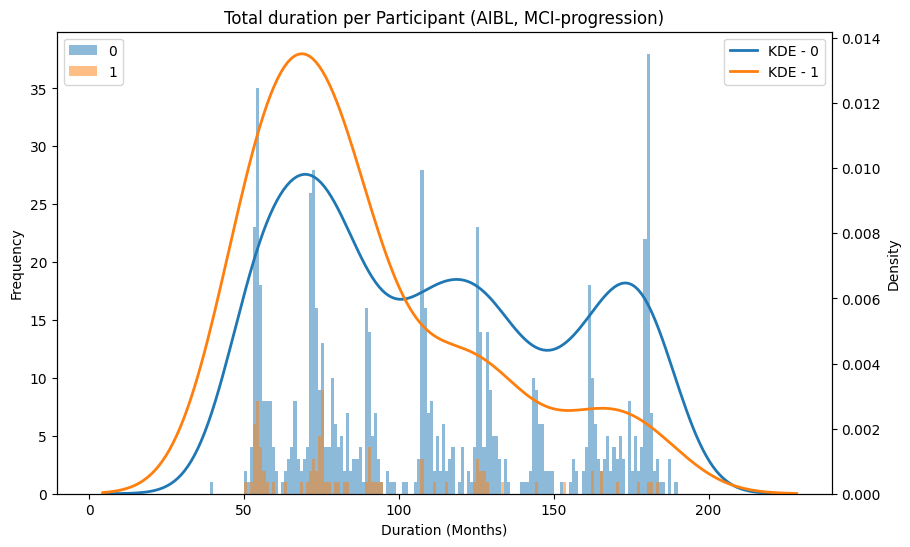

In [33]:
last_event = AIBL_survival.groupby('ID').last().reset_index()[['ID', 'event']]

# Calculate time duration (max(End) - min(Start))
time_duration = AIBL_survival.groupby('ID').agg({'start': 'min', 'stop': 'max'}).reset_index()
time_duration['Time'] = time_duration['stop'] - time_duration['start']

# Merge both
final_df = last_event.merge(time_duration[['ID', 'Time']], on='ID')
final_df['Time'] = final_df['Time'].astype(int)

fig, ax1 = plt.subplots(figsize=(10, 6))
for event, group in final_df.groupby('event'):
    ax1.hist(group['Time'], bins=range(1, final_df['Time'].max() + 2),
             alpha=0.5, label=event)

ax1.set_xlabel('Duration (Months)')
ax1.set_ylabel('Frequency')
ax1.set_title('Total duration per Participant (AIBL, MCI-progression)')
ax1.legend(title='Event')

# Create a second y-axis for KDE curve
ax2 = ax1.twinx()
for event, group in final_df.groupby('event'):
    sns.kdeplot(group['Time'], ax=ax2, label=f'KDE - {event}', linewidth=2)
ax2.set_ylabel('Density')


# Adjust legend placement
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [32]:
AIBL_survival.to_csv('../preprocessed_data/longitudinal_AIBL_MCI.csv', index=False)
NACC_survival.to_csv('../preprocessed_data/longitudinal_NACC_MCI.csv', index=False)